If the Glove file is not in the directory. Otherwise skip the command line section.

In [1]:
!wget "http://nlp.stanford.edu/data/glove.twitter.27B.zip"
!unzip -j glove.twitter.27B.zip

^C


In [2]:
import pandas as pd
import glob
import json
import numpy as np
import nltk
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import MaxPool1D
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

Using TensorFlow backend.


Import cleaned data: this includes all tweets that have been classified (both manually and by an automated labeling service):

In [7]:
tweets = pd.read_csv('cleaned_data.csv')[['label','text']]
tweets.text = tweets.text.astype(str)
tweets.head()

,label,text
0,0.0,in my personal opinion if you plan on committi...
1,0.0,they really going to allow the hashtag clinton...
2,0.0,that feel when you cant wait for work to be ov...
3,0.0,so let it be said that amonute matoaka powhata...
4,3.0,also your turn to die is now officially finish...


Clean up by dropping any NaN vals, label/clean up columns:

In [8]:
tweets = tweets.dropna()
tweets.shape

(11538, 2)

Use GloVe pretrained embeddings to seed embedding layer weights. Load GloVe weights trained on twitter dataset:

In [9]:
embeddings_idx = dict()
glove_file = open('glove.twitter.27B.100d.txt')
for line in glove_file:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_idx[word] = coefs
glove_file.close()
print('Loaded %s word vectors.' % len(embeddings_idx))

Loaded 1193514 word vectors.


For simplicity and due to the sparsity of the dataset, clump "depressed" and "suicidal" labels into one category (can refine this in future models/iteration; for first iteration, use binary classification):

In [12]:
text = np.asarray(tweets.text)
label_binary = tweets.label.replace(to_replace=3, value=1)
label = np.asarray(tweets.label)

np.unique(label_binary, return_counts = True)
label_binary.shape

(11538,)

Tokenize tweet texts. Use a max sentence length of 50 (with char limit of 280 and cleaning, this seems reasonable - by observation, most tweets still require padding), and pad all tweets out to this length:

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)
vocab_size = len(tokenizer.word_index) + 1
# integer encode the documents
encoded = tokenizer.texts_to_sequences(text)
# pad documents to a max length of 4 words
max_length = 50
padded_tweets = pad_sequences(encoded, maxlen=max_length, padding='post')

Split into train/test set of 90%/10%. These sets end up going unused, due to the cross fold validation, which splits the full dataset many times over.

In [14]:
text_train, text_test, label_train, label_test = train_test_split(padded_tweets, label_binary, test_size = 0.1, random_state = 0)

Split train set into train/validate. These sets end up going unused, due to the cross fold validation. 

In [15]:
text_train, text_val, label_train, label_val = train_test_split(text_train, label_train, test_size = 0.2, random_state = 0)

Include a function to calculate recall, as this may provide a more insightful metric for our model than accuracy, given the distribution of labels:

In [16]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

This function will print a history graph, including the training accuracy/validation accuracy/recall, and training loss/valication loss:

In [17]:
def print_history_graph(history):
    import matplotlib.pyplot as plt
    %matplotlib inline
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    recall = history.history['val_recall_m']
    epochs = range(1, len(acc)+1)
    
    print(str(history))
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.plot(epochs, recall, 'r', label='Recall')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend()
    plt.show()

    
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Initialize embedding matrix to seed embedding weights from the loaded GloVe embeddings:

In [18]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_idx.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Build embedding layer; make trainable based on our own small dataset, so embeddings are more specific to our text data. We could play with trainable vs. not trainable. Here we are using 100-dim GloVe vectors, weights = weights from those vectors, and 50-word sentences.

In [19]:
embedding_layer_fixed = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=50, trainable=False)
embedding_layer_trainable = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=50, trainable=True)

W0803 22:57:18.968810 4633568704 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



Define a function to train a model, given a model that has already been defined. This training contained in a function will be useful for cross-fold validation, defined in a function later. 

In [20]:
from keras import optimizers
from keras.callbacks import EarlyStopping
adam = optimizers.adam()
callbacks = [EarlyStopping(monitor='val_loss', patience=2)]


def train_model(model, text_train=text_train, label_train=label_train, text_val=text_val, label_val=label_val, callbacks = callbacks, verbose = 1, class_weight = None):
        history = model.fit(text_train, label_train, batch_size = 32, validation_data = (text_val, label_val), epochs = 50, callbacks = callbacks, verbose = verbose, class_weight = class_weight)
        return history

Create lists to keep track of accuracy of each model, recall of each model, along with model names, for comparison in model analysis:

In [21]:
model_names = []
model_acc = []
model_recall = []
model_acc_conf = []
model_recall_conf = []

K-fold cross validation was used to establish more confidence in the validation accuracy and validation recall for the model; the function below defined as `cross_val(model)` calculates an average validation accuracy and validation recall for the model over a 10-way split of the data, along with a confidence interval. 

Add the data for each model along with model names, so that models can be compared, to lists. 

In [22]:
skf = StratifiedKFold(n_splits = 10)

def cross_val(model, text, label, callbacks = callbacks, skf = skf, verbose = 0, class_weight = None):
    cvaccscores = []
    cvrecscores = []
    for TRAIN, TEST in skf.split(text, label):
        text_train, text_val = text[TRAIN], text[TEST]
        label_train, label_val = label[TRAIN], label[TEST]
        history = train_model(model[0], verbose = verbose, class_weight = class_weight)
        val_recall = history.history['val_recall_m'][-1]*100
        val_acc = history.history['val_acc'][-1]*100
        cvrecscores.append(val_recall)
        cvaccscores.append(val_acc)
    print("Acc: %.2f%% (+/- %.2f%%)" % (np.mean(cvaccscores), np.std(cvaccscores)))
    print("Recall: %.2f%% (+/- %.2f%%)" % (np.mean(cvrecscores), np.std(cvrecscores)))
    model_names.append(model[1])
    model_acc.append(np.mean(cvaccscores))
    model_acc_conf.append(np.std(cvaccscores))
    model_recall.append(np.mean(cvrecscores))
    model_recall_conf.append(np.std(cvrecscores))
        

Now, each CNN model can be defined, and variations on each model can be defined in each function. Each function building each model variation returns the model, and the name of the model, for analysis later. 

## Stacking layers: One layer -> four layers, starting with a kernel size of 2, reducing # of filters at each layer:

In [26]:
def cnn_one_layer():
    model = None
    model = Sequential()
    model.add(embedding_layer_fixed)
    model.add(Conv1D(128, 2, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc', recall_m])
    return model, 'Single Layer CNN'

In [27]:
def cnn_two_layer():
    model = None
    model = Sequential()
    model.add(embedding_layer_fixed)
    model.add(Conv1D(128, 2, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Conv1D(64, 2, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc', recall_m])
    return model, 'Two Layer CNN'

In [28]:
def cnn_three_layer():
    model = None
    model = Sequential()
    model.add(embedding_layer_fixed)
    model.add(Conv1D(128, 2, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Conv1D(64, 2, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Conv1D(32, 2, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc', recall_m])
    return model, 'Three Layer CNN'

In [29]:
def cnn_four_layer():
    model = None
    model = Sequential()
    model.add(embedding_layer_fixed)
    model.add(Conv1D(128, 2, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Conv1D(64, 2, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Conv1D(32, 2, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Conv1D(16, 2, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc', recall_m])
    return model, 'Four Layer CNN'

## Also take a look at four layers, with consistent (but much fewer) # of filters at each layer:

In [30]:
def cnn_four_layer_less():
    model = None
    model = Sequential()
    model.add(embedding_layer_fixed)
    model.add(Conv1D(32, 2, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Conv1D(32, 2, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Conv1D(32, 2, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Conv1D(32, 2, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc', recall_m])
    return model, 'Four Layer CNN, Reduced #Filters'


## Four layers, with trainable embeddings:

In [31]:
def cnn_four_layer_trainable():
    model = None
    model = Sequential()
    model.add(embedding_layer_fixed)
    model.add(Conv1D(128, 2, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Conv1D(64, 2, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Conv1D(32, 2, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Conv1D(16, 2, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc', recall_m])
    return model, 'Four Layer CNN, Trainable Embeddings'


## Kernel size = 3:
No improvement is seen by enlarging the kernel size (filter size) from 2 -> 3, despite the number of layers

In [32]:
def cnn_one_layer_k3():
    model = None
    model = Sequential()
    model.add(embedding_layer_fixed)
    model.add(Conv1D(128, 2, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc', recall_m])
    return model, 'Kernel Size = 3, 1 Layer CNN'

In [33]:
def cnn_two_layer_k3():
    model = None
    model = Sequential()
    model.add(embedding_layer_fixed)
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Conv1D(64, 3, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc', recall_m])
    return model, 'Kernel Size = 3, 2 Layer CNN'

In [34]:
def cnn_three_layer_k3():
    model = None
    model = Sequential()
    model.add(embedding_layer_fixed)
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Conv1D(64, 3, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Conv1D(32, 3, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc', recall_m])
    return model, 'Kernel Size = 3, 3 Layer CNN'

In [35]:
def cnn_four_layer_k3():
    model = None
    model = Sequential()
    model.add(embedding_layer_fixed)
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Conv1D(64, 3, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Conv1D(32, 3, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Conv1D(16, 3, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc', recall_m])
    return model, 'Kernel Size = 3, 4 Layer CNN'


In [36]:
def cnn_four_layer_k3_less():
    model = None
    model = Sequential()
    model.add(embedding_layer_fixed)
    model.add(Conv1D(32, 3, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Conv1D(32, 3, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Conv1D(32, 2, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Conv1D(16, 2, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc', recall_m])
    return model, '4 Layer CNN, K=3, Reduced Filters'


## Dropout:

In [37]:
def cnn_four_layer_dropout():
    model = None
    model = Sequential()
    model.add(embedding_layer_fixed)
    model.add(Conv1D(128, 2, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Conv1D(64, 2, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Conv1D(32, 2, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Conv1D(16, 2, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc', recall_m])
    return model, 'CNN With Dropout (rate = 0.2)'


In [38]:
def cnn_four_layer_dropout_k3():
    model = None
    model = Sequential()
    model.add(embedding_layer_fixed)
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Conv1D(64, 3, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Conv1D(32, 3, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Conv1D(16, 3, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc', recall_m])
    return model, 'CNN With Dropout, K=3 (rate = 0.2)'


## Combine the effects of adding dropout and less filters per layer:

In [39]:
def cnn_four_layer_dropout_k3_reduced_filters():
    model = None
    model = Sequential()
    model.add(embedding_layer_fixed)
    model.add(Conv1D(32, 3, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Conv1D(32, 3, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Conv1D(32, 3, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Conv1D(32, 3, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc', recall_m])
    return model, 'CNN With Dropout, K=3, Less Filters'


In [40]:
def cnn_four_layer_dropout_k2_reduced_filters():
    model = None
    model = Sequential()
    model.add(embedding_layer_fixed)
    model.add(Conv1D(32, 2, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Conv1D(32, 2, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Conv1D(32, 2, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Conv1D(32, 2, activation='relu'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc', recall_m])
    return model, 'CNN With Dropout, K=2, Less Filters'


## Adding kernel regularization:

In [41]:
from keras import regularizers

def cnn_four_layer_reg1():
    model = None
    model = Sequential()
    model.add(embedding_layer_fixed)
    model.add(Conv1D(128, 2, activation='relu', kernel_regularizer=regularizers.l1(0.001)))
    model.add(MaxPool1D(pool_size=2))
    #model.add(Dropout(0.2))
    model.add(Conv1D(64, 2, activation='relu', kernel_regularizer=regularizers.l1(0.001)))
    model.add(MaxPool1D(pool_size=2))
    #model.add(Dropout(0.2))
    model.add(Conv1D(32, 2, activation='relu', kernel_regularizer=regularizers.l1(0.001)))
    model.add(MaxPool1D(pool_size=2))
    #model.add(Dropout(0.2))
    model.add(Conv1D(16, 2, activation='relu',kernel_regularizer=regularizers.l1(0.001)))
    model.add(MaxPool1D(pool_size=2))
    #model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc', recall_m])
    return model, 'L1 Regularizer (0.001)'


def cnn_four_layer_reg2():
    model = None
    model = Sequential()
    model.add(embedding_layer_fixed)
    model.add(Conv1D(128, 2, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(MaxPool1D(pool_size=2))
    #model.add(Dropout(0.2))
    model.add(Conv1D(64, 2, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(MaxPool1D(pool_size=2))
    #model.add(Dropout(0.2))
    model.add(Conv1D(32, 2, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(MaxPool1D(pool_size=2))
    #model.add(Dropout(0.2))
    model.add(Conv1D(16, 2, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
    model.add(MaxPool1D(pool_size=2))
    #model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc', recall_m])
    return model, 'CNN, L2 Regularizer (0.001)'


def cnn_four_layer_reg2a():
    model = None
    model = Sequential()
    model.add(embedding_layer_fixed)
    model.add(Conv1D(128, 2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(MaxPool1D(pool_size=2))
    #model.add(Dropout(0.2))
    model.add(Conv1D(64, 2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(MaxPool1D(pool_size=2))
    #model.add(Dropout(0.2))
    model.add(Conv1D(32, 2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(MaxPool1D(pool_size=2))
    #model.add(Dropout(0.2))
    model.add(Conv1D(16, 2, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(MaxPool1D(pool_size=2))
    #model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc', recall_m])
    return model, 'CNN, L2 Regularizer (0.01)'




## Running cross validation (10-fold) on all models):

In [42]:
cross_val(cnn_one_layer(), padded_tweets, label_binary)
cross_val(cnn_two_layer(), padded_tweets, label_binary)
cross_val(cnn_three_layer(), padded_tweets, label_binary)
cross_val(cnn_four_layer(), padded_tweets, label_binary)

cross_val(cnn_four_layer_less(),padded_tweets,label_binary)
cross_val(cnn_four_layer_trainable(), padded_tweets, label_binary)
cross_val(cnn_four_layer_dropout(), padded_tweets, label_binary)
cross_val(cnn_four_layer_reg1(), padded_tweets, label_binary)
cross_val(cnn_four_layer_reg2(), padded_tweets, label_binary)
cross_val(cnn_four_layer_reg2a(), padded_tweets, label_binary)

cross_val(cnn_one_layer_k3(), padded_tweets, label_binary)
cross_val(cnn_two_layer_k3(), padded_tweets, label_binary)
cross_val(cnn_three_layer_k3(), padded_tweets, label_binary)
cross_val(cnn_four_layer_k3(), padded_tweets, label_binary)
cross_val(cnn_four_layer_k3_less(), padded_tweets, label_binary)

cross_val(cnn_four_layer_dropout_k3(), padded_tweets, label_binary)
cross_val(cnn_four_layer_dropout_k3_reduced_filters(), padded_tweets, label_binary)


W0803 22:58:00.628780 4633568704 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0803 22:58:00.631024 4633568704 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0803 22:58:00.638427 4633568704 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0803 22:58:00.639303 4633568704 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.

Acc: 80.09% (+/- 0.96%)
Recall: 46.71% (+/- 5.38%)
Acc: 79.52% (+/- 1.23%)
Recall: 46.59% (+/- 5.29%)
Acc: 79.37% (+/- 0.89%)
Recall: 38.33% (+/- 7.33%)
Acc: 79.84% (+/- 0.86%)
Recall: 49.82% (+/- 4.21%)
Acc: 79.82% (+/- 0.84%)
Recall: 37.49% (+/- 7.80%)
Acc: 79.51% (+/- 1.09%)
Recall: 39.58% (+/- 3.10%)
Acc: 79.79% (+/- 1.35%)
Recall: 48.13% (+/- 3.03%)
Acc: 80.37% (+/- 0.62%)
Recall: 45.70% (+/- 3.62%)
Acc: 79.02% (+/- 2.16%)
Recall: 48.47% (+/- 9.77%)
Acc: 78.16% (+/- 1.21%)
Recall: 46.47% (+/- 3.30%)
Acc: 79.02% (+/- 0.64%)
Recall: 46.97% (+/- 5.45%)
Acc: 77.11% (+/- 2.13%)
Recall: 52.53% (+/- 3.62%)


In [47]:
cross_val(cnn_four_layer_dropout_k2_reduced_filters(), padded_tweets, label_binary)


Acc: 78.72% (+/- 1.28%)
Recall: 54.47% (+/- 4.76%)


## This function will return the prediction from a given model, given a tweet to classify:

In [35]:
def predict_tweet(text, model):
    text = clean_txt(text)
    encoded = tokenizer.texts_to_sequences([text])
    padded_tweet = pad_sequences(encoded, maxlen=50, padding='post')
    if model.predict_classes(padded_tweet)[0][0] == 0:
        print('No depressive sentiment detected')
    else:
        print('Depressive sentiment detected')


## Produce graphs for analysis:

W0802 18:38:34.558035 4635030976 legend.py:1282] No handles with labels found to put in legend.


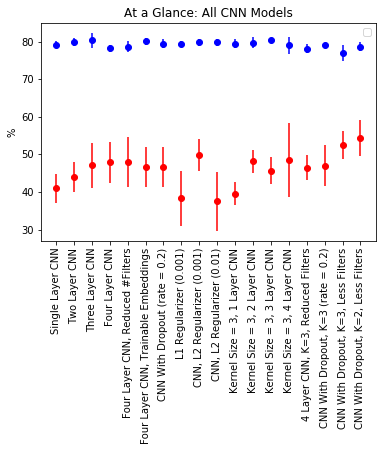

In [48]:
#all models
import matplotlib.pyplot as plt
x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17, 18]
#plt.plot(x, model_acc, 'bo', label='Accuracy')
#plt.plot(x, model_recall, 'ro', label='Recall')
plt.errorbar(x, model_acc, yerr=model_acc_conf, fmt = 'bo')
plt.errorbar(x, model_recall, yerr=model_recall_conf, fmt = 'ro')
plt.xticks(x,model_names,rotation='vertical')
plt.title('At a Glance: All CNN Models')
plt.ylabel('%')
plt.legend()
plt.show()

W0802 18:38:41.027858 4635030976 legend.py:1282] No handles with labels found to put in legend.


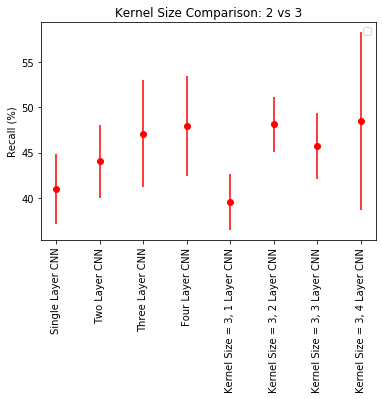

In [49]:
#Kernel size comparison
x = [1,2,3,4,5,6,7,8]
#plt.plot(x, model_recall[0:4] +model_recall[10:14], 'ro', label='Recall')
plt.errorbar(x, model_recall[0:4] +model_recall[10:14], yerr=model_recall_conf[0:4] + model_recall_conf[10:14], fmt = 'ro')
plt.xticks(x,model_names[0:4] + model_names[10:14],rotation='vertical')
plt.title('Kernel Size Comparison: 2 vs 3')
plt.ylabel('Recall (%)')
plt.legend()
plt.show()

W0802 18:39:03.178001 4635030976 legend.py:1282] No handles with labels found to put in legend.


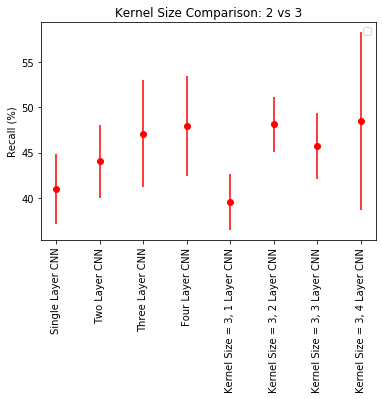

In [50]:
#Kernel size comparison
x = [1,2,3,4,5,6,7,8]
plt.errorbar(x, model_recall[0:4] +model_recall[10:14], yerr=model_recall_conf[0:4] + model_recall_conf[10:14], fmt = 'ro')
plt.xticks(x,model_names[0:4] + model_names[10:14],rotation='vertical')
plt.title('Kernel Size Comparison: 2 vs 3')
plt.ylabel('Recall (%)')
plt.legend()
plt.show()

In [ ]:
#Trainable embeddings

W0802 18:39:05.897974 4635030976 legend.py:1282] No handles with labels found to put in legend.


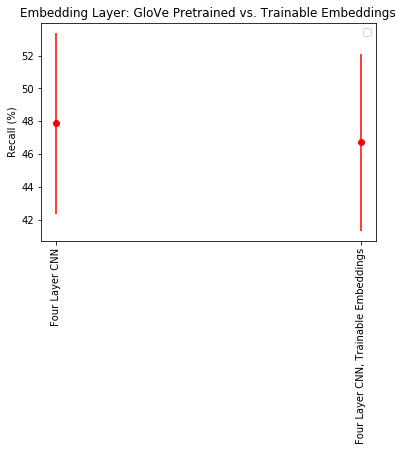

In [51]:
x = [2,3]
plt.errorbar(x,[ model_recall[3]] + [model_recall[5]], yerr=[model_recall_conf[3]] + [model_recall_conf[5]], fmt = 'ro')
plt.xticks(x,[model_names[3]] + [model_names[5]],rotation='vertical')
plt.title('Embedding Layer: GloVe Pretrained vs. Trainable Embeddings')
plt.ylabel('Recall (%)')
plt.legend()
plt.show()

W0802 18:39:10.464236 4635030976 legend.py:1282] No handles with labels found to put in legend.


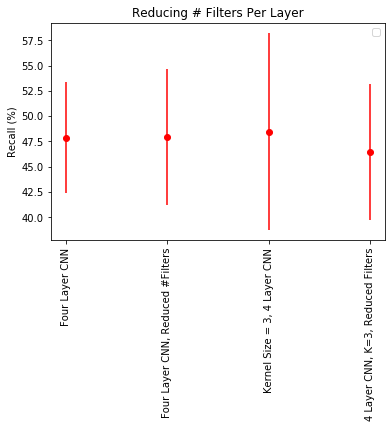

In [52]:
x = [1,2,3,4]
plt.errorbar(x,[ model_recall[3]] + [model_recall[4]]+[ model_recall[13]] + [model_recall[14]], yerr=[model_recall_conf[3]] + [model_recall_conf[4]]+[model_recall_conf[13]] + [model_recall_conf[4]], fmt = 'ro')
plt.xticks(x,[model_names[3]] + [model_names[4]]+[model_names[13]] + [model_names[14]],rotation='vertical')
plt.title('Reducing # Filters Per Layer')
plt.ylabel('Recall (%)')
plt.legend()
plt.show()

W0802 18:39:24.665111 4635030976 legend.py:1282] No handles with labels found to put in legend.


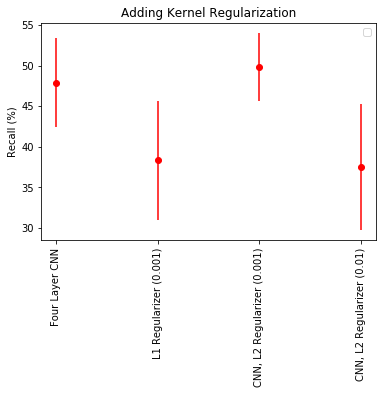

In [53]:
x = [1,2,3,4]
plt.errorbar(x,[ model_recall[3]] + [model_recall[7]]+[ model_recall[8]] + [model_recall[9]], yerr=[model_recall_conf[3]] + [model_recall_conf[7]]+[model_recall_conf[8]] + [model_recall_conf[9]], fmt = 'ro')
plt.xticks(x,[model_names[3]] + [model_names[7]]+[model_names[8]] + [model_names[9]],rotation='vertical')
plt.title('Adding Kernel Regularization')
plt.ylabel('Recall (%)')
plt.legend()
plt.show()

W0802 18:39:33.192553 4635030976 legend.py:1282] No handles with labels found to put in legend.


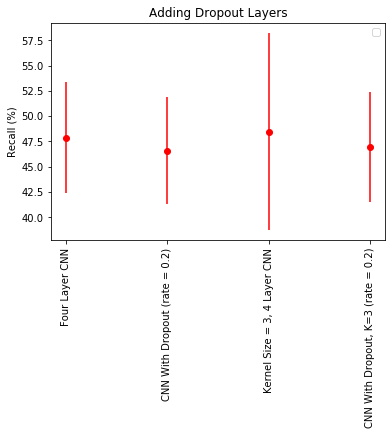

In [54]:
x = [1,2,3,4]
plt.errorbar(x,[ model_recall[3]] + [model_recall[6]]+[ model_recall[13]] + [model_recall[15]], yerr=[model_recall_conf[3]] + [model_recall_conf[6]]+[model_recall_conf[13]] + [model_recall_conf[15]], fmt = 'ro')
plt.xticks(x,[model_names[3]] + [model_names[6]]+[model_names[13]] + [model_names[15]],rotation='vertical')
plt.title('Adding Dropout Layers')
plt.ylabel('Recall (%)')
plt.legend()
plt.show()

W0802 18:39:37.222864 4635030976 legend.py:1282] No handles with labels found to put in legend.


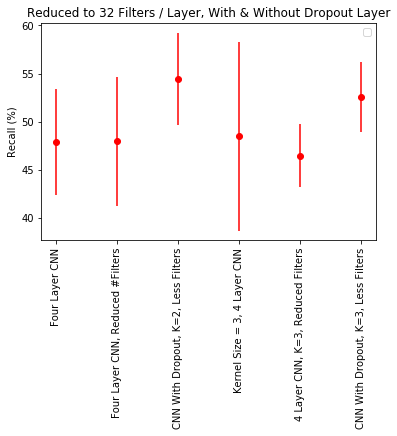

In [55]:
x = [1,2,3,4,5,6]
plt.errorbar(x,[ model_recall[3]]+[model_recall[4]] + [model_recall[17]]+[ model_recall[13]]+[model_recall[14]] + [model_recall[16]], yerr=[model_recall_conf[3]] + [model_recall_conf[4]]+[model_recall_conf[17]]+[model_recall_conf[13]] +[model_recall_conf[14]] + [model_recall_conf[16]], fmt = 'ro')
plt.xticks(x,[model_names[3]] + [model_names[4]]+[model_names[17]]+[model_names[13]] + [model_names[14]]+[model_names[16]],rotation='vertical')
plt.title('Reduced to 32 Filters / Layer, With & Without Dropout Layer')
plt.ylabel('Recall (%)')
plt.legend()
plt.show()

## Examine highest performaning models with class weight parameter:
Change class_weight parameter from none to {0:1.,1:3.} to examine model performance

In [59]:
#cross_val(cnn_four_layer_dropout_k2_reduced_filters(), padded_tweets, label_binary, class_weight = {0:1.,1:3.})
#cross_val(cnn_four_layer_dropout_k3_reduced_filters(), padded_tweets, label_binary, class_weight = {0:1.,1:3.})
cross_val(cnn_four_layer_dropout_k2_reduced_filters(), padded_tweets, label_binary, class_weight = {0:1.,1:10.})
cross_val(cnn_four_layer_dropout_k3_reduced_filters(), padded_tweets, label_binary, class_weight = {0:1.,1:10.})

Acc: 65.06% (+/- 5.49%)
Recall: 82.30% (+/- 7.03%)
Acc: 68.96% (+/- 4.51%)
Recall: 77.67% (+/- 7.16%)


In [71]:
model_acc


[79.2489167208504,
 79.86037553619408,
 80.39480020291656,
 78.31006256042907,
 78.72412131764766,
 80.08666345977875,
 79.51853634476605,
 79.37409726197065,
 79.84111698189204,
 79.81704381692276,
 79.51372171802822,
 79.78815598963084,
 80.37072701585024,
 79.01781414154348,
 78.16080886811434,
 79.02262877717752,
 77.10640344759796,
 78.72412132855268,
 73.24506497893933,
 73.32209915855381,
 65.06499759411663,
 68.96485314096002]

W0802 19:07:09.927226 4635030976 legend.py:1282] No handles with labels found to put in legend.


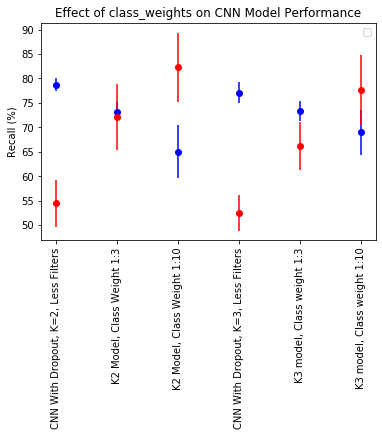

In [68]:
x = [1,2,3,4,5,6]
plt.errorbar(x,[model_acc[17]]+[model_acc[18]]+[model_acc[20]] + [model_acc[16]]+[model_acc[19]]+[model_acc[21]], yerr=[model_acc_conf[17]] + [model_acc_conf[18]]+ [model_acc_conf[20]]+[model_acc_conf[16]]+[model_acc_conf[19]]+ [model_acc_conf[21]],  fmt = 'bo')
plt.errorbar(x,[model_recall[17]]+[model_recall[18]]+[model_recall[20]] + [model_recall[16]]+[model_recall[19]]+[model_recall[21]], yerr=[model_recall_conf[17]] + [model_recall_conf[18]]+ [model_recall_conf[20]]+[model_recall_conf[16]]+[model_recall_conf[19]]+ [model_recall_conf[21]],  fmt = 'ro')
plt.xticks(x,[model_names[17]] + ['K2 Model, Class Weight 1:3'] + ['K2 Model, Class Weight 1:10']+[model_names[16]]+['K3 model, Class weight 1:3'] + ['K3 model, Class weight 1:10'] ,rotation='vertical')
plt.title('Effect of class_weights on CNN Model Performance')
plt.ylabel('Recall (%)')
plt.legend()
plt.show()